## 3.1 Computational Graph

chain rule ∂y/∂u = ∂y/∂v · ∂v/∂u

In [26]:
import numpy as np

def sigmoid(x):
    # Stable sigmoid: handles large |x| values safely
    x = np.clip(x, -500, 500)
    return 1 / (1 + np.exp(-x))
    
def numeric_jacobian(func, x, h=1e-5):
    """Vector-valued func, vector x -> Jacobian matrix"""
    x = np.asarray(x, dtype=float)
    y0 = func(x)
    m, n = len(y0), len(x)
    J = np.empty((m, n))
    for j in range(n):
        dx = np.zeros_like(x)
        dx[j] = h
        J[:, j] = (func(x + dx) - func(x - dx)) / (2 * h)
    return J

In [27]:
class CompGraph:
    def __init__(self):
        # storage for intermediate values
        self.x1 = self.x2 = self.x3 = None
        self.z1 = self.z2 = self.z3 = None
        self.u1 = self.u2 = self.u3 = None
        self.v1 = self.v2 = self.v3 = None
        self.y1 = self.y2 = None

    def forward(self, x1, x2, x3):
        self.x1, self.x2, self.x3 = x1, x2, x3
        self.z1 = 2*x1 + x2
        self.z2 = x1 * 3*x3
        self.z3 = -x3 * 2*x2
        self.u1 = np.sin(self.z1)
        self.u2 = 6*x3 + 2*self.z2
        self.u3 = 2*self.z1 + self.z3
        self.v1 = self.u1 + np.cos(self.u3)
        self.v2 = np.sin(-self.u2)
        self.v3 = self.u1 * self.u3
        self.y1 = self.v1**2 + self.v2**3
        self.y2 = self.v2 * self.v3
        return np.array([self.y1, self.y2])

    # ---------- analytic back-prop ----------
    def backward(self):
        # dy/dv  (2×3)
        dy1_dv1 = 2 * self.v1
        dy1_dv2 = 3 * self.v2**2
        dy1_dv3 = 0.0
        dy2_dv1 = 0.0
        dy2_dv2 = self.v3
        dy2_dv3 = self.v2
        J_yv = np.array([[dy1_dv1, dy1_dv2, dy1_dv3],
                         [dy2_dv1, dy2_dv2, dy2_dv3]])

        # dv/du  (3×3)
        dv1_du1 = 1.0
        dv1_du2 = 0.0
        dv1_du3 = -np.sin(self.u3)
        dv2_du1 = 0.0
        dv2_du2 = -np.cos(-self.u2)
        dv2_du3 = 0.0
        dv3_du1 = self.u3
        dv3_du2 = 0.0
        dv3_du3 = self.u1
        J_vu = np.array([[dv1_du1, dv1_du2, dv1_du3],
                         [dv2_du1, dv2_du2, dv2_du3],
                         [dv3_du1, dv3_du2, dv3_du3]])

        # dy/du  (2×3)
        J_yu = J_yv @ J_vu

        return J_yv, J_vu, J_yu


# ---------- run ----------
x = np.array([1., 1., 1.])
model = CompGraph()
y = model.forward(*x)
J_yv, J_vu, J_yu = model.backward()

print("Forward output y1, y2 =", y)
print()
print("J_yv = ∂y/∂v\n", J_yv)
print()
print("J_vu = ∂v/∂u\n", J_vu)
print()
print("J_yu = ∂y/∂u (analytic)\n", J_yu)
print()
print("Chain-rule check: J_yv @ J_vu\n", J_yv @ J_vu)

Forward output y1, y2 = [0.41716543 0.3028847 ]

J_yv = ∂y/∂v
 [[-1.02504723  0.86373149  0.        ]
 [ 0.          0.56448003  0.53657292]]

J_vu = ∂v/∂u
 [[ 1.          0.          0.7568025 ]
 [ 0.         -0.84385396  0.        ]
 [ 4.          0.          0.14112001]]

J_yu = ∂y/∂u (analytic)
 [[-1.02504723 -0.72886324 -0.7757583 ]
 [ 2.14629167 -0.47633871  0.07572117]]

Chain-rule check: J_yv @ J_vu
 [[-1.02504723 -0.72886324 -0.7757583 ]
 [ 2.14629167 -0.47633871  0.07572117]]


In [125]:
"""
2-hidden-layer FFNN implemented with NumPy for the OCR dataset.
- Switch datasets by changing `dataset_size = 'small'|'medium'|'large'`.
- Switch activation with activation_type = 'sigmoid' or 'relu'.
"""
import pandas as pd
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

In [126]:
# -----------------------------
# Configuration / hyperparams
# -----------------------------
# dataset_size = 'large'   # 'small', 'medium', or 'large'
datasets = ['small', 'medium', 'large']

# Network architecture
H1 = 128   # hidden layer 1 units
H2 = 62   # hidden layer 2 units

label_map = {0:'a',1:'e',2:'g',3:'i',4:'l',5:'n',6:'o',7:'r',8:'t',9:'u'}

# Training hyperparameters
epochs = 20
batch_size = 64
lr = 0.5
activation_type = 'sigmoid'  # 'sigmoid' or 'relu'

seed = 0
np.random.seed(seed)

In [127]:
# -----------------------------
# Utility math & activations
# -----------------------------
def sigmoid(x):
    # Prevent overflow in exp() by clipping extreme values
    x = np.clip(x, -60, 60)
    return 1.0 / (1.0 + np.exp(-x))

def sigmoid_grad_from_sigma(sig_x):
    # If sig_x = σ(x), then σ'(x) = σ(x)*(1-σ(x))
    return sig_x * (1.0 - sig_x)

def relu(x):
    # ReLU(x) = max(0, x) (elementwise)
    return np.maximum(0.0, x)

def relu_grad(x):
    # ReLU'(x) = 1 if x > 0 else 0 (elementwise)
    g = np.zeros_like(x)
    g[x > 0] = 1.0
    return g

def softmax(logits):
    """
    Softmax row-wise with numeric stability
    For row i: softmax_i_j = exp(logit_i_j - m_i) / sum_k exp(logit_i_k - m_i)
    where m_i = max_k logit_i_k
    """
    # shift = logits - m (broadcast)
    m = np.max(logits, axis=1, keepdims=True)          # m_i = max_k logits[i,k]   (shape N x 1)
    shift = logits - m                                 # shift[i,j] = logits[i,j] - m_i
    exp_shift = np.exp(shift)                          # exp_shift[i,j] = exp(shift[i,j])
    sum_exp = np.sum(exp_shift, axis=1, keepdims=True) # sum_exp[i] = sum_k exp_shift[i,k]
    probs = exp_shift / sum_exp                        # probs[i,j] = exp_shift[i,j] / sum_exp[i]
    return probs

def cross_entropy_loss(probs, y_onehot):
    """
    L = - (1/N) * sum_{i=1..N} sum_{k=1..K} y_{i,k} * log(probs_{i,k})
    We clip probs to avoid log(0).
    """
    N = probs.shape[0]
    clipped = np.clip(probs, 1e-12, 1.0)
    return -np.sum(y_onehot * np.log(clipped)) / N



===== DATASET: SMALL =====


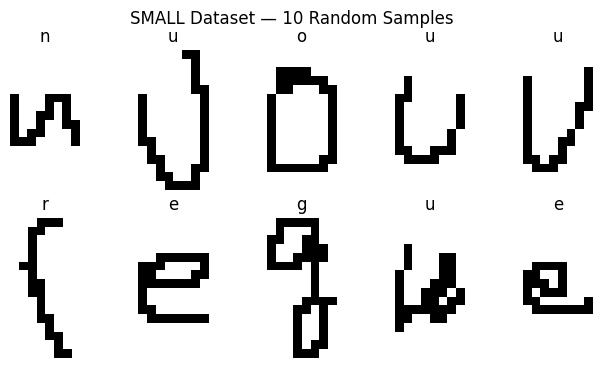


===== DATASET: MEDIUM =====


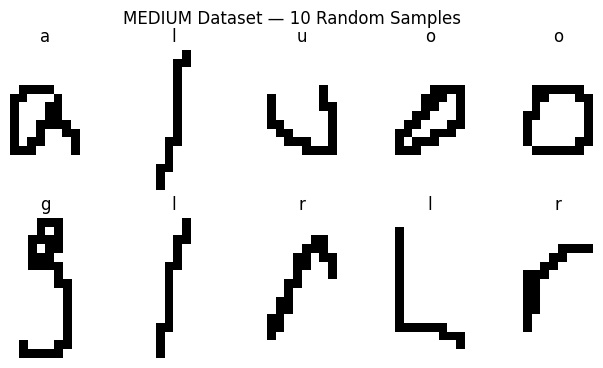


===== DATASET: LARGE =====


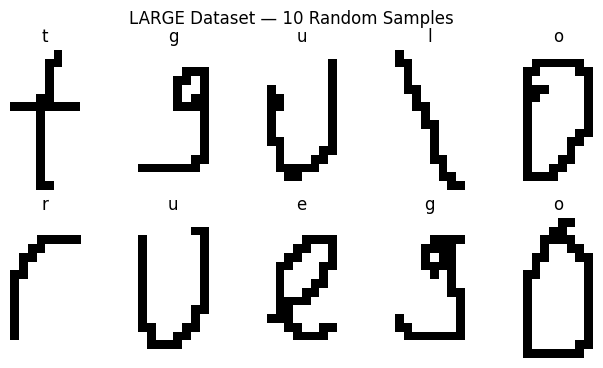

In [128]:
def load_dataset(train_path, split_ratio=0.2):
    """
    Load {dataset_size}Train.csv and split into train/test internally (no Validation.csv).
    Splits each dataset into (1 - split_ratio) train and split_ratio test.
    """
    train_path = os.path.join(f"./图像分类-dataset/{dataset_size}Train.csv")
    df = pd.read_csv(train_path, header=None)

    # separate labels and pixel data
    y = df.iloc[:, 0].values.astype(int)  # labels (shape N,)
    X = df.iloc[:, 1:].values.astype(np.float32)  # pixels (shape N x 128)

    # normalize to [0,1]
    if X.max() > 1.0:
        X /= 255.0  # elementwise: X[i,j] = X[i,j] / 255

    # split into train/test
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=split_ratio, stratify=y, random_state=0
    )

    # one-hot encode labels for loss (K classes)
    enc = OneHotEncoder(sparse_output=False, categories='auto')
    y_train_onehot = enc.fit_transform(y_train.reshape(-1, 1))  # shape (N_train, K)
    y_val_onehot = enc.transform(y_val.reshape(-1, 1))  # shape (N_val, K)

    return X_train, y_train, y_train_onehot, X_val, y_val, y_val_onehot

# M = X_train.shape[1]   # input dim (128)
# K = y_train_onehot.shape[1]  # number of classes, expected 10

def show_samples(X, y, dataset_name):
    indices = np.random.choice(len(X), 10, replace=False)
    fig, axes = plt.subplots(2,5, figsize=(8,4))
    for ax, idx in zip(axes.flatten(), indices):
        ax.imshow(1 - X[idx].reshape(16,8), cmap='gray', vmin=0, vmax=1)
        ax.set_title(f'{label_map[y[idx]]}')
        ax.axis('off')
    plt.suptitle(f'{dataset_name.upper()} Dataset — 10 Random Samples')
    plt.show()
    
for name in datasets:
    print(f"\n===== DATASET: {name.upper()} =====")
    X_train, y_train, y_train_1hot, X_val, y_val, y_val_1hot = load_dataset(train_path, split_ratio=0.2)
    show_samples(X_train, y_train, name)

In [129]:
# -----------------------------
# Helper: choose activation
# -----------------------------
def activation_forward(z):
    if activation_type == 'sigmoid':
        return sigmoid(z)        # a = σ(z)
    elif activation_type == 'relu':
        return relu(z)           # a = max(0, z)
    else:
        raise ValueError("activation_type must be 'sigmoid' or 'relu'")

def activation_backward(z, a):
    """
    Return derivative φ'(z).
    For sigmoid: we pass a = σ(z) and compute σ'(z) = a*(1-a).
    For ReLU: need to compute indicator(z>0).
    """
    if activation_type == 'sigmoid':
        return sigmoid_grad_from_sigma(a)  # φ'(z) elementwise
    elif activation_type == 'relu':
        return relu_grad(z)
    else:
        raise ValueError("activation_type must be 'sigmoid' or 'relu'")

In [130]:
# -----------------------------
# Training loop
# -----------------------------
def train_model(X_train, y_train, y_train_1hot,
                X_test, y_test, y_test_1hot,
                learning_rate=0.5, epochs=200, batch_size=64,
                activation_function='relu'):
    num_batches = int(np.ceil(X_train.shape[0] / batch_size))
    loss_history = []

    # -----------------------------
    # Parameter initialization
    # -----------------------------
    # Xavier / Glorot-like initialization: normal(0, sqrt(2/(n_in + n_out)))
    W1 = np.random.normal(0.0, np.sqrt(2.0 / (M + H1)), size=(M, H1))   # shape (M, H1)
    b1 = np.zeros((1, H1))                                               # shape (1, H1)
    
    W2 = np.random.normal(0.0, np.sqrt(2.0 / (H1 + H2)), size=(H1, H2))  # shape (H1, H2)
    b2 = np.zeros((1, H2))                                               # shape (1, H2)
    
    W3 = np.random.normal(0.0, np.sqrt(2.0 / (H2 + K)), size=(H2, K))    # shape (H2, K)
    b3 = np.zeros((1, K)) 

    # alias learning_rate for consistency with original lr variable
    lr = learning_rate

    for epoch in range(1, epochs + 1):
        # shuffle dataset each epoch
        X_shuf, y_shuf, yoh_shuf = shuffle(X_train, y_train, y_train_1hot, random_state=epoch)
        epoch_loss_sum = 0.0

        for b in range(num_batches):
            start = b * batch_size
            end = min((b+1) * batch_size, X_shuf.shape[0])
            Xb = X_shuf[start:end]        # shape (N, M)
            yb = yoh_shuf[start:end]      # shape (N, K)
            N = Xb.shape[0]

            # --------------------------
            # Forward propagation
            # --------------------------
            z1 = Xb.dot(W1) + b1          # shape (N, H1)
            a1 = activation_forward(z1)   # shape (N, H1)
            z2 = a1.dot(W2) + b2          # shape (N, H2)
            a2 = activation_forward(z2)   # shape (N, H2)
            z3 = a2.dot(W3) + b3          # shape (N, K)
            probs = softmax(z3)           # shape (N, K)

            # loss (average cross-entropy over batch)
            loss = cross_entropy_loss(probs, yb)
            epoch_loss_sum += loss * N

            # --------------------------
            # Backward propagation
            # --------------------------
            delta3 = (probs - yb) / N     # shape (N, K)
            dW3 = a2.T.dot(delta3)        # shape (H2, K)
            db3 = np.sum(delta3, axis=0, keepdims=True)  # shape (1, K)

            temp2 = delta3.dot(W3.T)      # shape (N, H2)
            delta2 = temp2 * activation_backward(z2, a2)  # shape (N, H2)
            dW2 = a1.T.dot(delta2)        # shape (H1, H2)
            db2 = np.sum(delta2, axis=0, keepdims=True)  # shape (1, H2)

            temp1 = delta2.dot(W2.T)      # shape (N, H1)
            delta1 = temp1 * activation_backward(z1, a1)  # shape (N, H1)
            dW1 = Xb.T.dot(delta1)        # shape (M, H1)
            db1 = np.sum(delta1, axis=0, keepdims=True)  # shape (1, H1)

            # --------------------------
            # Parameter update (SGD)
            # --------------------------
            W3 -= lr * dW3; b3 -= lr * db3
            W2 -= lr * dW2; b2 -= lr * db2
            W1 -= lr * dW1; b1 -= lr * db1

        # --------------------------
        # End of epoch: compute loss and accuracy
        # --------------------------
        epoch_loss = epoch_loss_sum / X_train.shape[0]
        loss_history.append(epoch_loss)

        # Validation / test forward pass
        z1_v = X_test.dot(W1) + b1
        a1_v = activation_forward(z1_v)
        z2_v = a1_v.dot(W2) + b2
        a2_v = activation_forward(z2_v)
        z3_v = a2_v.dot(W3) + b3
        probs_v = softmax(z3_v)
        preds_v = np.argmax(probs_v, axis=1)
        val_acc = np.mean(preds_v == y_test)

        if (epoch % 20 == 0) or (epoch == 1):
            print(f"Epoch {epoch:3d}/{epochs} — Train Loss: {epoch_loss:.4f}, Test Acc: {val_acc*100:.2f}%")

    np.savez(os.path.join(f"./ffnn_{dataset_size}_{activation_type}_params.npz"),
         W1=W1, b1=b1, W2=W2, b2=b2, W3=W3, b3=b3)
    print("\nFinished training. Parameters saved to disk.")
    # Return everything needed for later analysis
    return loss_history, val_acc, preds_v, probs_v



===== TRAINING ON SMALL DATASET =====
Epoch   1/20 — Train Loss: 2.3860, Test Acc: 16.00%
Epoch  20/20 — Train Loss: 1.3777, Test Acc: 51.00%

Finished training. Parameters saved to disk.
Final Accuracy on SMALL: 51.00%

===== TRAINING ON MEDIUM DATASET =====
Epoch   1/20 — Train Loss: 2.2738, Test Acc: 26.40%
Epoch  20/20 — Train Loss: 0.4782, Test Acc: 82.90%

Finished training. Parameters saved to disk.
Final Accuracy on MEDIUM: 82.90%

===== TRAINING ON LARGE DATASET =====
Epoch   1/20 — Train Loss: 2.0790, Test Acc: 35.44%
Epoch  20/20 — Train Loss: 0.3709, Test Acc: 84.89%

Finished training. Parameters saved to disk.
Final Accuracy on LARGE: 84.89%


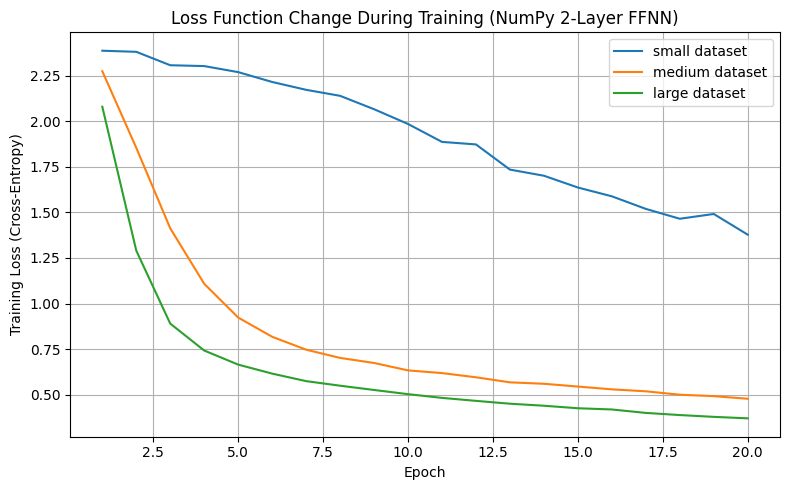


Summary of Final Accuracies:
Small     : 51.00%
Medium    : 82.90%
Large     : 84.89%


In [131]:
# ==============================================================
# Plot Loss Function Changes for Small, Medium, and Large Datasets
# ==============================================================

loss_curves = {}
accuracies = {}

for dataset_size in ['small', 'medium', 'large']:
    print(f"\n===== TRAINING ON {dataset_size.upper()} DATASET =====")

    X_train, y_train, y_train_1hot, X_val, y_val, y_val_1hot = load_dataset(train_path, split_ratio=0.2)

    # Recalculate input/output dimensions for this dataset
    M = X_train.shape[1]
    K = y_train_1hot.shape[1]

    # Train the model using your existing train_model() function
    loss_history, val_acc, preds, probs = train_model(
        X_train, y_train, y_train_1hot,
        X_val, y_val, y_val_1hot,
        learning_rate=lr, epochs=epochs, batch_size=batch_size,
        activation_function=activation_type
    )

    loss_curves[dataset_size] = loss_history
    accuracies[dataset_size] = val_acc

    print(f"Final Accuracy on {dataset_size.upper()}: {val_acc*100:.2f}%")

# --------------------------------------------------------------
# Plot all three loss curves on the same graph for comparison
# --------------------------------------------------------------
plt.figure(figsize=(8,5))
for name, losses in loss_curves.items():
    plt.plot(range(1, len(losses)+1), losses, label=f"{name} dataset")

plt.xlabel("Epoch")
plt.ylabel("Training Loss (Cross-Entropy)")
plt.title("Loss Function Change During Training (NumPy 2-Layer FFNN)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --------------------------------------------------------------
# Print summary of final accuracies
# --------------------------------------------------------------
print("\nSummary of Final Accuracies:")
for ds, acc in accuracies.items():
    print(f"{ds.capitalize():<10}: {acc*100:.2f}%")

# Save final weights if desired




===== SMALL DATASET — 5 SAMPLE PREDICTIONS =====
Epoch   1/20 — Train Loss: 2.3738, Test Acc: 12.00%
Epoch  20/20 — Train Loss: 1.3927, Test Acc: 50.00%


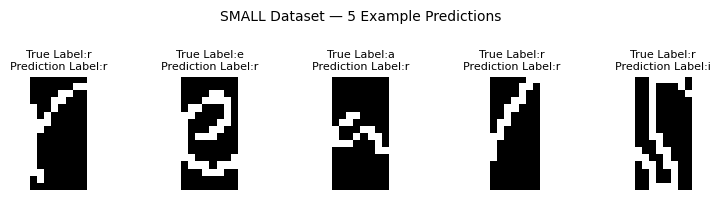


===== MEDIUM DATASET — 5 SAMPLE PREDICTIONS =====
Epoch   1/20 — Train Loss: 2.2570, Test Acc: 27.20%
Epoch  20/20 — Train Loss: 0.4794, Test Acc: 82.60%


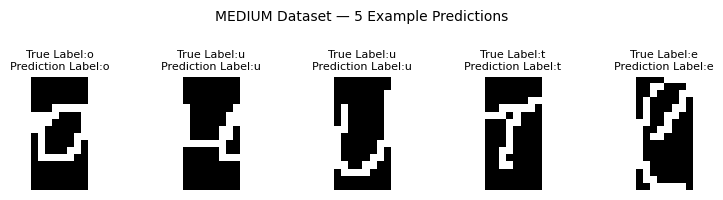


===== LARGE DATASET — 5 SAMPLE PREDICTIONS =====
Epoch   1/20 — Train Loss: 2.0572, Test Acc: 37.39%
Epoch  20/20 — Train Loss: 0.3795, Test Acc: 85.61%


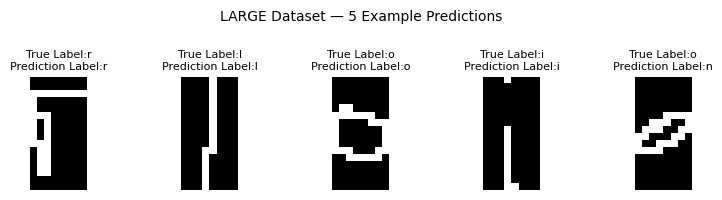

In [36]:
# ==============================================================
# Show 5 test samples (image + True/Predicted labels) per dataset
# ==============================================================

for dataset_size in ['small', 'medium', 'large']:
    print(f"\n===== {dataset_size.upper()} DATASET — 5 SAMPLE PREDICTIONS =====")

    # Load dataset (split internally into train/test)
    train_path = os.path.join(f"./图像分类-dataset/{dataset_size}Train.csv")
    X_train, y_train, y_train_1hot, X_val, y_val, y_val_1hot = load_dataset(train_path, split_ratio=0.2)

    # Infer input/output dimensions
    M = X_train.shape[1]
    K = y_train_1hot.shape[1]

    # Train model
    loss_history, val_acc, preds_v, probs_v = train_model(
        X_train, y_train, y_train_1hot,
        X_val, y_val, y_val_1hot,
        learning_rate=lr, epochs=epochs, batch_size=batch_size,
        activation_function=activation_type
    )

    # Pick 5 random test samples
    sample_indices = np.random.choice(len(X_val), 5, replace=False)
    fig, axes = plt.subplots(1, 5, figsize=(8, 2))

    for i, ax in enumerate(axes):
        idx = sample_indices[i]
        image = X_val[idx].reshape(16, 8)
        true_label = label_map[y_val[idx]]
        pred_label = label_map[preds_v[idx]]

        ax.imshow(image, cmap='gray', vmin=0, vmax=1)
        ax.set_title(f"True Label:{true_label}\nPrediction Label:{pred_label}", fontsize=8)
        ax.axis('off')

    plt.suptitle(f"{dataset_size.upper()} Dataset — 5 Example Predictions", fontsize=10)
    plt.tight_layout()
    plt.show()



===== PyTorch TRAINING ON SMALL DATASET =====
Epoch   1/20 — Train Loss: 2.3876, Val Acc: 10.00%
Epoch   5/20 — Train Loss: 2.3706, Val Acc: 10.00%
Epoch  10/20 — Train Loss: 2.3385, Val Acc: 10.00%
Epoch  15/20 — Train Loss: 2.3229, Val Acc: 10.00%
Epoch  20/20 — Train Loss: 2.3049, Val Acc: 10.00%
Final Accuracy (SMALL): 10.00%


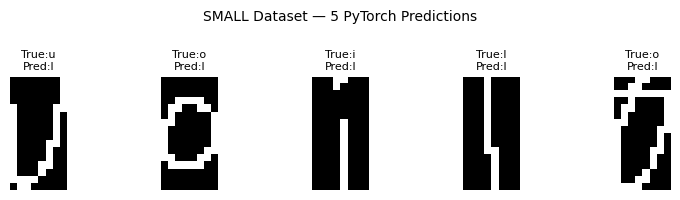


===== PyTorch TRAINING ON MEDIUM DATASET =====
Epoch   1/20 — Train Loss: 2.3299, Val Acc: 10.00%
Epoch   5/20 — Train Loss: 1.6440, Val Acc: 40.20%
Epoch  10/20 — Train Loss: 0.8738, Val Acc: 78.20%
Epoch  15/20 — Train Loss: 0.6662, Val Acc: 81.00%
Epoch  20/20 — Train Loss: 0.5744, Val Acc: 82.40%
Final Accuracy (MEDIUM): 82.40%


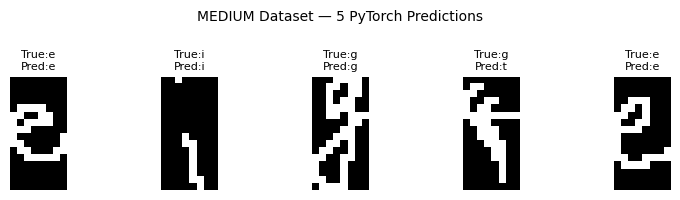


===== PyTorch TRAINING ON LARGE DATASET =====
Epoch   1/20 — Train Loss: 2.3205, Val Acc: 10.00%
Epoch   5/20 — Train Loss: 0.9525, Val Acc: 74.11%
Epoch  10/20 — Train Loss: 0.5979, Val Acc: 79.94%
Epoch  15/20 — Train Loss: 0.4949, Val Acc: 82.50%
Epoch  20/20 — Train Loss: 0.4314, Val Acc: 84.00%
Final Accuracy (LARGE): 84.00%


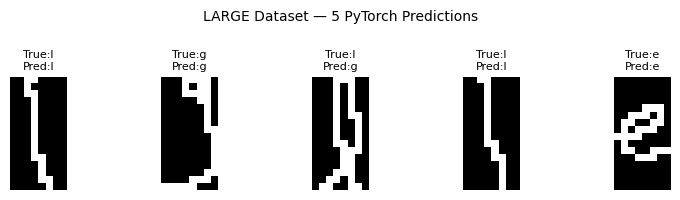

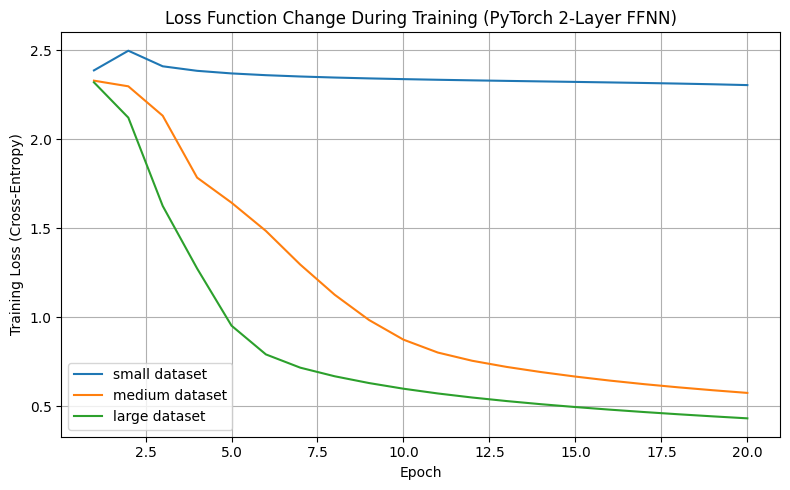


Summary of Final Accuracies (PyTorch):
Small     : 10.00%
Medium    : 82.40%
Large     : 84.00%


In [133]:
# ==============================================================
# PyTorch Implementation of the same FNN (Letter Classification)
# ==============================================================

import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(seed)

# --------------------------------------------------------------
# 1. Define the PyTorch Feedforward Neural Network
# --------------------------------------------------------------
class FNNClassifierTorch(nn.Module):
    def __init__(self, input_dim, hidden1=128, hidden2=62, output_dim=10):
        super(FNNClassifierTorch, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        x = self.fc3(x)  # logits
        return x

# --------------------------------------------------------------
# 2. Helper: convert NumPy → Torch tensors
# --------------------------------------------------------------
def to_torch(X, y):
    X_t = torch.tensor(X, dtype=torch.float32)
    y_t = torch.tensor(y, dtype=torch.long)
    return X_t, y_t

# --------------------------------------------------------------
# 3. Train + Evaluate the model
# --------------------------------------------------------------
def train_torch_model(X_train, y_train, X_val, y_val, learning_rate=0.5, epochs=20, batch_size=64):
    input_dim = X_train.shape[1]
    output_dim = len(np.unique(y_train))

    model = FNNClassifierTorch(input_dim, H1, H2, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    X_train_t, y_train_t = to_torch(X_train, y_train)
    X_val_t, y_val_t = to_torch(X_val, y_val)

    num_batches = int(np.ceil(len(X_train_t) / batch_size))
    loss_history = []

    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0.0

        # Mini-batch training
        for i in range(num_batches):
            start, end = i * batch_size, min((i + 1) * batch_size, len(X_train_t))
            xb, yb = X_train_t[start:end], y_train_t[start:end]

            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * len(xb)

        # Compute average epoch loss
        avg_loss = epoch_loss / len(X_train_t)
        loss_history.append(avg_loss)

        # Validation accuracy
        model.eval()
        with torch.no_grad():
            logits_val = model(X_val_t)
            preds_val = torch.argmax(logits_val, dim=1)
            acc = (preds_val == y_val_t).float().mean().item()

        if (epoch == 1) or (epoch % 5 == 0):
            print(f"Epoch {epoch:3d}/{epochs} — Train Loss: {avg_loss:.4f}, Val Acc: {acc*100:.2f}%")

    return model, loss_history, acc, preds_val

# --------------------------------------------------------------
# 4. Train and evaluate on small / medium / large datasets
# --------------------------------------------------------------
torch_loss_curves = {}
torch_accuracies = {}

for dataset_size in ['small', 'medium', 'large']:
    print(f"\n===== PyTorch TRAINING ON {dataset_size.upper()} DATASET =====")

    train_path = os.path.join(f"./图像分类-dataset/{dataset_size}Train.csv")
    X_train, y_train, y_train_1hot, X_val, y_val, y_val_1hot = load_dataset(train_path, split_ratio=0.2)

    model, loss_hist, val_acc, preds_val = train_torch_model(
        X_train, y_train, X_val, y_val,
        learning_rate=lr, epochs=epochs, batch_size=batch_size
    )

    torch_loss_curves[dataset_size] = loss_hist
    torch_accuracies[dataset_size] = val_acc

    print(f"Final Accuracy ({dataset_size.upper()}): {val_acc*100:.2f}%")

    # ----------------------------------------------------------
    # Display 5 random test samples (True vs Predicted)
    # ----------------------------------------------------------
    sample_indices = np.random.choice(len(X_val), 5, replace=False)
    fig, axes = plt.subplots(1, 5, figsize=(8, 2))

    for i, ax in enumerate(axes):
        idx = sample_indices[i]
        img = X_val[idx].reshape(16, 8)
        true_label = label_map[y_val[idx]]
        pred_label = label_map[preds_val[idx].item()]

        ax.imshow(img, cmap='gray', vmin=0, vmax=1)
        ax.set_title(f"True:{true_label}\nPred:{pred_label}", fontsize=8)
        ax.axis('off')

    plt.suptitle(f"{dataset_size.upper()} Dataset — 5 PyTorch Predictions", fontsize=10)
    plt.tight_layout()
    plt.show()

# --------------------------------------------------------------
# 5. Plot PyTorch Loss Curves for Comparison
# --------------------------------------------------------------
plt.figure(figsize=(8,5))
for name, losses in torch_loss_curves.items():
    plt.plot(range(1, len(losses)+1), losses, label=f"{name} dataset")
plt.xlabel("Epoch")
plt.ylabel("Training Loss (Cross-Entropy)")
plt.title("Loss Function Change During Training (PyTorch 2-Layer FFNN)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --------------------------------------------------------------
# 6. Print Summary
# --------------------------------------------------------------
print("\nSummary of Final Accuracies (PyTorch):")
for ds, acc in torch_accuracies.items():
    print(f"{ds.capitalize():<10}: {acc*100:.2f}%")


In [112]:
# ==============================================================
# FFNN Regression (NumPy + PyTorch)
# Based on 回归-dataset
# ==============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# --------------------------
# 1) Load dataset
# --------------------------
train_df = pd.read_csv("./回归-dataset/data_train.csv", header=None, skiprows=1)
valid_df = pd.read_csv("./回归-dataset/data_valid.csv", header=None, skiprows=1)
test_df  = pd.read_csv("./回归-dataset/data_test.csv",  header=None, skiprows=1)

X_all = train_df.iloc[:, 0].to_numpy(float).reshape(-1, 1)
Y_all = train_df.iloc[:, 1].to_numpy(float).reshape(-1, 1)
perm = np.random.permutation(len(X_all))
X_all, Y_all = X_all[perm], Y_all[perm]

X_train, Y_train = X_all[:1800], Y_all[:1800]
X_test_ID, Y_test_ID = X_all[1800:], Y_all[1800:]
X_test_OOD = np.concatenate([
    valid_df.iloc[:, 0].to_numpy(float).reshape(-1, 1),
    test_df.iloc[:, 0].to_numpy(float).reshape(-1, 1)
], axis=0)
Y_test_OOD = np.concatenate([
    valid_df.iloc[:, 1].to_numpy(float).reshape(-1, 1),
    test_df.iloc[:, 1].to_numpy(float).reshape(-1, 1)
], axis=0)

# ==============================================================
# 2. Visualize In-Distribution and Out-of-Distribution Sets
# ==============================================================
plt.figure(figsize=(6,4))
plt.scatter(X_train, Y_train, s=10, c='blue', label="Train Data (ID)")
plt.scatter(X_test_ID, Y_test_ID, s=10, c='gold', label="Test Data (ID)")
plt.scatter(X_test_OOD, Y_test_OOD, s=10, c='limegreen', label="Test Data (OOD)")
plt.axvline(x=2.0, color='black', linestyle='--', label="OOD Boundary")
plt.legend()
plt.title("Dataset Distribution: In-Distribution (ID) vs Out-of-Distribution (OOD)")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

print("Train:", X_train.shape, "| ID-Test:", X_test_ID.shape, "| OOD-Test:", X_test_OOD.shape)

# --------------------------
# 2) Normalization
# --------------------------
def fit_norm(X, Y):
    return X.mean(0, keepdims=True), X.std(0, keepdims=True), Y.mean(0, keepdims=True), Y.std(0, keepdims=True)
def apply_norm(X, Y, X_mu, X_sd, Y_mu, Y_sd):
    return ( (X - X_mu) / (X_sd + 1e-8), (Y - Y_mu) / (Y_sd + 1e-8) )
def denorm_Y(Yn, Y_mu, Y_sd): return Yn * (Y_sd + 1e-8) + Y_mu

X_mu, X_sd, Y_mu, Y_sd = fit_norm(X_train, Y_train)
Xtr_n, Ytr_n = apply_norm(X_train, Y_train, X_mu, X_sd, Y_mu, Y_sd)
Xid_n, Yid_n = apply_norm(X_test_ID, Y_test_ID, X_mu, X_sd, Y_mu, Y_sd)
Xod_n, Yod_n = apply_norm(X_test_OOD, Y_test_OOD, X_mu, X_sd, Y_mu, Y_sd)

# ==============================================================
# NumPy Implementation
# ==============================================================

def sigmoid(x): x = np.clip(x, -60, 60); return 1.0 / (1.0 + np.exp(-x))
def tanh(x): return np.tanh(x)
def relu(x): return np.maximum(0, x)
def sin(x): return np.sin(x)
def batch_norm(z, eps=1e-8): mu=z.mean(0,keepdims=True); sd=z.std(0,keepdims=True); return (z-mu)/(sd+eps)
def mse(y, t): return 0.5*np.mean((y-t)**2)
def rmse_denorm(yh, yt, Y_mu, Y_sd): return np.sqrt(np.mean((denorm_Y(yh,Y_mu,Y_sd)-denorm_Y(yt,Y_mu,Y_sd))**2))

acts = {'sigmoid':sigmoid, 'tanh':tanh, 'relu':relu, 'sin':sin}
acts_deriv = {
    'sigmoid':lambda a: a*(1-a),
    'tanh':lambda a: 1-a**2,
    'relu':lambda a: (a>0).astype(float),
    'sin':lambda a: np.cos(a)
}

def train_numpy(Xtr, Ytr, Xid, Yid, Xod, Yod, act_name='sigmoid',
                hidden1=64, hidden2=32, lr=0.02, epochs=20000, bn=True):
    np.random.seed(42)
    f, df = acts[act_name], acts_deriv[act_name]
    N,M = Xtr.shape
    W1 = np.random.randn(M,hidden1)*np.sqrt(2/(M+hidden1)); b1=np.zeros((1,hidden1))
    W2 = np.random.randn(hidden1,hidden2)*np.sqrt(2/(hidden1+hidden2)); b2=np.zeros((1,hidden2))
    W3 = np.random.randn(hidden2,1)*np.sqrt(2/(hidden2+1)); b3=np.zeros((1,1))

    def forward(X):
        z1 = X@W1+b1; a1=f(batch_norm(z1) if bn else z1)
        z2 = a1@W2+b2; a2=f(batch_norm(z2) if bn else z2)
        z3 = a2@W3+b3; return z1,a1,z2,a2,z3

    snap={0:(W1.copy(),b1.copy(),W2.copy(),b2.copy(),W3.copy(),b3.copy())}
    tr_hist,id_hist,od_hist=[],[],[]

    for ep in range(1,epochs+1):
        z1,a1,z2,a2,yhat=forward(Xtr)
        dY=(yhat-Ytr)/N
        dW3=a2.T@dY; db3=dY.sum(0,keepdims=True)
        d2=(dY@W3.T)*df(a2); dW2=a1.T@d2; db2=d2.sum(0,keepdims=True)
        d1=(d2@W2.T)*df(a1); dW1=Xtr.T@d1; db1=d1.sum(0,keepdims=True)
        W3-=lr*dW3; b3-=lr*db3; W2-=lr*dW2; b2-=lr*db2; W1-=lr*dW1; b1-=lr*db1

        if ep%1000==0:
            fwd=lambda X: forward(X)[-1]
            tr,idt,ood = mse(fwd(Xtr),Ytr), mse(fwd(Xid),Yid), mse(fwd(Xod),Yod)
            tr_hist.append(tr); id_hist.append(idt); od_hist.append(ood)
            print(f"[{act_name}] Epoch {ep:5d} | MSE Train={tr:.4f} ID={idt:.4f} OOD={ood:.4f}")

        if ep in (0,100,200): snap[ep]=(W1.copy(),b1.copy(),W2.copy(),b2.copy(),W3.copy(),b3.copy())
    snap['final']=(W1.copy(),b1.copy(),W2.copy(),b2.copy(),W3.copy(),b3.copy())
    return snap,tr_hist,id_hist,od_hist,lambda X:forward(X)[-1]

def predict_rawY(X,params,act_name,bn=True):
    f=acts[act_name]; W1,b1,W2,b2,W3,b3=params
    Xn=(X-X_mu)/(X_sd+1e-8)
    z1=Xn@W1+b1; a1=f(batch_norm(z1) if bn else z1)
    z2=a1@W2+b2; a2=f(batch_norm(z2) if bn else z2)
    y=a2@W3+b3
    return denorm_Y(y,Y_mu,Y_sd)
    
name_map = {
    "relu": "Linear",
    "sigmoid": "Quadratic",
    "tanh": "Tanh",
    "sin": "Periodic"
}

def plot_panels(act_name,snap,tr_hist,id_hist,od_hist):
    fig,ax=plt.subplots(1,5,figsize=(18,3.6)); plt.subplots_adjust(wspace=0.35)
    xg=np.linspace(-4,6,400).reshape(-1,1)
    y_min,y_max=Y_train.min(),Y_train.max(); margin=0.05*(y_max-y_min)
    stages=[("Init",snap[0]),("Epoch 100",snap[100]),("Epoch 200",snap[200]),("Final",snap['final'])]
    for i,(t,p) in enumerate(stages):
        ax[i].set_title(f"{act_name.upper()} - {t}")
        ax[i].set_xlim(-4,6); ax[i].set_ylim(y_min-margin,y_max+margin)
        ax[i].axvspan(2,6,color='gray',alpha=0.15); ax[i].axvline(x=2,color='black',ls='--')
        ax[i].scatter(X_train,Y_train,s=10,c='blue',label='Train')
        ax[i].scatter(X_test_ID,Y_test_ID,s=10,c='gold',label='ID')
        ax[i].scatter(X_test_OOD,Y_test_OOD,s=10,c='lime',label='OOD')
        ax[i].plot(xg,predict_rawY(xg,p,act_name,bn=True),c='red',lw=2)
        if i==0: ax[i].legend(fontsize=8)
    e=np.arange(len(tr_hist))*1000
    ax[-1].plot(e,tr_hist,label='Train',c='blue'); ax[-1].plot(e,id_hist,label='ID',c='orange'); ax[-1].plot(e,od_hist,label='OOD',c='green')
    ax[-1].set_title("Loss (MSE)"); ax[-1].set_xlabel("Epochs"); ax[-1].grid(True); ax[-1].legend(fontsize=8)
    exp_name = name_map[act]
    plt.suptitle(f"NumPy FFNN Regression ({exp_name})",y=1.03)
    plt.show()

for act in ['sigmoid','tanh','relu','sin']:
    snap,tr_hist,id_hist,od_hist,predict = train_numpy(Xtr_n,Ytr_n,Xid_n,Yid_n,Xod_n,Yod_n,act_name=act,epochs=20000)
    plot_panels(act,snap,tr_hist,id_hist,od_hist)
    print(f"{act.upper()} RMSE (Train/ID/OOD):",
          rmse_denorm(predict(Xtr_n),Ytr_n,Y_mu,Y_sd),
          rmse_denorm(predict(Xid_n),Yid_n,Y_mu,Y_sd),
          rmse_denorm(predict(Xod_n),Yod_n,Y_mu,Y_sd))


In [120]:
# ==============================================================
# PyTorch FFNN Regression (Experiment 3.3 Style)
# ==============================================================
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

# ==============================================================
# 1. Load Datasets
# ==============================================================
train_df = pd.read_csv("./回归-dataset/data_train.csv", header=None, skiprows=1)
valid_df = pd.read_csv("./回归-dataset/data_valid.csv", header=None, skiprows=1)
test_df  = pd.read_csv("./回归-dataset/data_test.csv", header=None, skiprows=1)

# Convert to NumPy arrays
X_all = train_df.iloc[:, 0].to_numpy(dtype=float).reshape(-1, 1)
Y_all = train_df.iloc[:, 1].to_numpy(dtype=float).reshape(-1, 1)

# Random shuffle and split
np.random.seed(42)
idx = np.random.permutation(len(X_all))
X_all, Y_all = X_all[idx], Y_all[idx]
X_train, Y_train = X_all[:1800], Y_all[:1800]
X_test_ID, Y_test_ID = X_all[1800:], Y_all[1800:]

# OOD test set
X_test_OOD = np.concatenate([
    valid_df.iloc[:, 0].values.reshape(-1, 1),
    test_df.iloc[:, 0].values.reshape(-1, 1)
])
Y_test_OOD = np.concatenate([
    valid_df.iloc[:, 1].values.reshape(-1, 1),
    test_df.iloc[:, 1].values.reshape(-1, 1)
])

# Normalize input/output
X_mu, X_sd = X_train.mean(), X_train.std()
Y_mu, Y_sd = Y_train.mean(), Y_train.std()

def norm_X(x): return (x - X_mu) / (X_sd + 1e-8)
def norm_Y(y): return (y - Y_mu) / (Y_sd + 1e-8)
def denorm_Y(y): return y * (Y_sd + 1e-8) + Y_mu

X_train_t = torch.tensor(norm_X(X_train), dtype=torch.float32)
Y_train_t = torch.tensor(norm_Y(Y_train), dtype=torch.float32)
X_ID_t = torch.tensor(norm_X(X_test_ID), dtype=torch.float32)
Y_ID_t = torch.tensor(norm_Y(Y_test_ID), dtype=torch.float32)
X_OOD_t = torch.tensor(norm_X(X_test_OOD), dtype=torch.float32)
Y_OOD_t = torch.tensor(norm_Y(Y_test_OOD), dtype=torch.float32)

# ==============================================================
# 2. Define Model Architectures for Various Activations
# ==============================================================
class Sin(nn.Module):
    def forward(self, x): return torch.sin(x)

def get_activation(name):
    if name == 'sigmoid': return nn.Sigmoid()
    if name == 'tanh': return nn.Tanh()
    if name == 'relu': return nn.ReLU()
    if name == 'sin': return Sin()
    raise ValueError("Unknown activation type")

class FFNN(nn.Module):
    def __init__(self, act_type='sigmoid'):
        super().__init__()
        act = get_activation(act_type)
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            act,
            nn.Linear(64, 32),
            act,
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

# ==============================================================
# 3. Training Function (with Model Snapshots)
# ==============================================================
def train_torch(act='sigmoid', lr=1e-3, epochs=20000):
    model = FFNN(act)
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    train_hist, id_hist, od_hist = [], [], []
    snapshots = {}

    for epoch in range(epochs + 1):
        model.train()
        opt.zero_grad()
        y_pred = model(X_train_t)
        loss = loss_fn(y_pred, Y_train_t)
        loss.backward()
        opt.step()

        if epoch % 1000 == 0:
            model.eval()
            with torch.no_grad():
                id_pred = model(X_ID_t)
                od_pred = model(X_OOD_t)
                id_loss = loss_fn(id_pred, Y_ID_t).item()
                od_loss = loss_fn(od_pred, Y_OOD_t).item()

            train_hist.append(loss.item())
            id_hist.append(id_loss)
            od_hist.append(od_loss)
            print(f"Epoch {epoch:5d}: Train={loss.item():.4f}, ID={id_loss:.4f}, OOD={od_loss:.4f}")

            # Store snapshots at key epochs
            if epoch in [0, 1000, 5000, 20000]:
                snapshots[epoch] = copy.deepcopy(model)

    return model, snapshots, train_hist, id_hist, od_hist

# ==============================================================
# 4. Visualization Function (4 Regression Stages + Loss)
# ==============================================================
def plot_torch_regression_stages(model_snapshots, act, train_hist, id_hist, od_hist):
    fig, axes = plt.subplots(1, 5, figsize=(18, 3.5))
    plt.subplots_adjust(wspace=0.3)

    x_grid = torch.linspace(-4, 6, 400).view(-1, 1)
    X_mu_t = torch.tensor(X_mu, dtype=torch.float32)
    X_sd_t = torch.tensor(X_sd, dtype=torch.float32)

    colors = {"train": "blue", "id": "gold", "ood": "lime"}
    y_lim = [0, 25]

    for i, (epoch, snapshot) in enumerate(model_snapshots.items()):
        ax = axes[i]
        ax.set_title(f"Epoch {epoch}" if epoch > 0 else "Initial Model")
        ax.set_xlim(-4, 6)
        ax.set_ylim(y_lim)
        ax.set_xlabel("X")
        if i == 0:
            ax.set_ylabel("Y")

        ax.axvspan(2, 6, color='gray', alpha=0.15)
        ax.axvline(x=2, color='black', linestyle='--')

        ax.scatter(X_train, Y_train, s=10, c=colors["train"], label="Train")
        ax.scatter(X_test_ID, Y_test_ID, s=10, c=colors["id"], label="ID Test")
        ax.scatter(X_test_OOD, Y_test_OOD, s=10, c=colors["ood"], label="OOD Test")

        model = snapshot.eval()
        with torch.no_grad():
            yg = model((x_grid - X_mu_t) / (X_sd_t + 1e-8))
        yg = denorm_Y(yg.numpy())

        ax.plot(x_grid, yg, color='red', lw=2, label='FFNN Prediction')
        if i == 0:
            ax.legend(fontsize=8)

    # Loss Curve
    ax = axes[-1]
    epochs = np.arange(len(train_hist)) * 1000
    ax.plot(epochs, train_hist, label='Train Loss', color='blue')
    ax.plot(epochs, id_hist, label='ID Loss', color='orange')
    ax.plot(epochs, od_hist, label='OOD Loss', color='green')
    ax.set_title("Loss Curves")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss (MSE)")
    ax.legend(fontsize=8)
    ax.grid(True)

    fig.suptitle(f"PyTorch FFNN Regression ({act})", fontsize=12, y=1.02)
    plt.show()

# ==============================================================
# 5. Run Experiments for All Activations
# ==============================================================
for act in ['sigmoid', 'tanh', 'relu', 'sin']:
    exp_name = name_map[act]
    print(f"\n===== Training PyTorch FFNN ({exp_name.upper()}) =====")
    model, snapshots, tr_hist, id_hist, od_hist = train_torch(act)
    plot_torch_regression_stages(snapshots, act, tr_hist, id_hist, od_hist)
